In [ ]:
#| hide
#| default_exp parallel
from nbdev import *

# Parallel calculations

> Parallel/async variants of some routines.

Presently the w-estimation routine is fully parallelized for VASP. It should be trivial to extend this to any calculator based on external process execution (e.g. abinit or any other which runs blocking shell script to execute the calculation). The support for internal calculators (e.g. ASAP3) should be possible but is not trivial. Support for internal calculators is not planned at the moment.

In [ ]:
#| hide
#|exporti
from fastcore.basics import patch

In [ ]:
#| hide
#|exporti
import ase
from ase.calculators.vasp import Vasp
from ase.calculators import calculator
from ase.calculators.vasp.vasp import check_atoms
from ase import units as un
import asyncio
from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm
from scipy import stats
import numpy as np

In [ ]:
#| hide
#|exporti
from hecss import *
import hecss
from hecss.util import write_dfset, calc_init_xscale
from hecss.optimize import make_sampling

In [ ]:
#| hide
from glob import glob
from tempfile import TemporaryDirectory
import os
import subprocess
from collections import defaultdict
from matplotlib import pyplot as plt


In [ ]:
#|exporti

def __run_async(func, *args, **kwargs):
    '''
    Run async methods detecting running loop in jupyter.
    '''
    try:
        loop = asyncio.get_running_loop()
    except RuntimeError:  # 'RuntimeError: There is no current event loop...'
        loop = None
    
    if loop and loop.is_running():        
        # print('Async event loop already running. Running in new thread.')
        # Create a separate thread so we can block before returning
        with ThreadPoolExecutor(1) as pool:
            result = pool.submit(lambda: asyncio.run(func(*args, **kwargs))).result()
    else:
        # print('Starting new event loop')
        result = asyncio.run(func(*args, **kwargs))
    return result

In [ ]:
#|exporti

@patch
async def _arun(self: Vasp, command=None, out=None, directory=None):
    """
    Method to explicitly execute VASP in async mode
    This is an asyncio version of the function.
    """
    # DEBUG
    # print(f'Async _run {command} in {directory}')
    if command is None:
        command = self.command
    if directory is None:
        directory = self.directory

    proc = await asyncio.create_subprocess_shell(
            command,
            stdout=asyncio.subprocess.PIPE,
            stderr=asyncio.subprocess.PIPE,
            cwd=directory
            )

    stdout, stderr = await proc.communicate()

    # DEBUG
    # print(f'[{command!r} exited with {proc.returncode}]')
    # if stdout:
    #     print(f'[stdout]\n{stdout.decode()}')
    # if stderr:
    #     print(f'[stderr]\n{stderr.decode()}')
    
    return proc.returncode

In [ ]:
#|exporti

@patch
async def __calculate_aio(self: Vasp,
                        atoms=None,
                        properties=('energy', ),
                        system_changes=tuple(calculator.all_changes)
                       ):
    """
    Do a VASP calculation in the specified directory.
    
    This will generate the necessary VASP input files, and then
    execute VASP. After execution, the energy, forces. etc. are read
    from the VASP output files.

    This is an asyncio version of the function.
    """
    # Check for zero-length lattice vectors and PBC
    # and that we actually have an Atoms object.
    check_atoms(atoms)
    
    self.clear_results()
    
    if atoms is not None:
        self.atoms = atoms.copy()
    
    command = self.make_command(self.command)
    self.write_input(self.atoms, properties, system_changes)
    
    with self._txt_outstream() as out:
        errorcode = await self._arun(command=command,
                                     out=out,
                                     directory=self.directory)
    
    if errorcode:
        raise calculator.CalculationFailed(
            '{} in {} returned an error: {:d}'.format(
                self.name, self.directory, errorcode))
    
    # Read results from calculation
    self.update_atoms(atoms)
    self.read_results()
    return errorcode

In [ ]:
#|exporti

@patch 
async def __estimate_width_scale_aio(self: HECSS, n=1, Tmax=600, set_scale=True, pbar=None, nwork=5):
    '''
    Async/parallel version of w-estimator. Only supported for VASP.
    Estimate coefficient between temperature and displacement scale (eta).
    Calculate energy increase from the `n` temperatures uniformly 
    distributed between 0 and `Tmax` and calculate avarage $\sqrt{E-E0/T}$
    which is a width scale for a given temperature:
    $$
        w = \\eta\\sqrt{T}
    $$
    which comes from the assumed approximate relationship:
    $$
        \\frac{E(w(T))-E_0}{T} \\approx \\mathrm{const} = \\eta^2.
    $$
    
    #### Input
    * `n`    - number of sampling points
    * `Tmax` - max sampled temperature
    * `set_scale` - set scale parameter in the class after run
    * `pbar` - show progress bar during calculation
    * `nwork` -
    
    #### Output
    * if wm_out :  mean(eta), std(eta), wm
    * else : mean(eta), std(eta)
    * wm - the nx3 array of: [width, Temperature, (E-E0)/nat]
    '''
    results = []
    
    async def worker(q, i):
        while not q.empty():
            (T, w, dx, clc) = await q.get()
            try:
                # print(f'Worker {i} run task')
                returned = await clc.__calculate_aio(clc.atoms)
                # print(f'Worker {i} done task')
                results.append((T, w, dx, clc))
                if pbar:
                    pbar.update()
            except Exception as e:
                print(f"Error executing task: {e}")

    
    # print('Parallel estimate_width_scale')
    nat = len(self.cryst)
    dim = (nat, 3)    
    
    # try:
    #     [task_queue.put_nowait(asyncio.create_task(fetch_data(root_path=row['1']))) 
    #      for index, row in run_column.iterrows()]
    #     await asyncio.gather(*[worker(task_queue) for _ in range(5)]) 
    # except Exception as e:
    #     print(f"\nUnable to get data: {e}\n")
 
    
    if pbar:
       pbar.set_description('Create') 

    # Build the queue
    structs = asyncio.Queue()    
    while structs.qsize() < n - len(self._eta_list):
        cr = ase.Atoms(self.cryst.get_atomic_numbers(), 
                       cell=self.cryst.get_cell(),
                       scaled_positions=self.cryst.get_scaled_positions(),
                       pbc=True, 
                      )
        
        T = stats.uniform.rvs(0, Tmax) # Kelvin
        if not T:
            continue
        w = self.w_scale * np.sqrt(T)
        dx = self.Q.rvs(size=dim, scale=w)

        clc = self.calc.__class__()
        clc.fromdict(self.calc.asdict())
        clc.atoms.set_positions(self.cryst.get_positions()+dx)
        try :
            clc.set(directory=f'{self.directory}/w_est/{len(self._eta_list)+structs.qsize():03d}')
        except AttributeError :
            # Calculator is not directory-based
            # Ignore the error
            pass
        clc.set(command=self.calc.command)
        structs.put_nowait((T, w, dx, clc))
        if pbar:
            pbar.update()
            
    if pbar:
        pbar.reset(structs.qsize())
        pbar.set_description('Collect') 

    if nwork is None or nwork < 1:
        nwork = structs.qsize()
    await asyncio.gather(*[worker(structs, _) for _ in range(nwork)]) 

    while results:
        T, w, dx, clc = results.pop()
        E = clc.get_potential_energy()
        i = len(self._eta_list)
        self._eta_samples.append((i, i, dx, clc.get_forces(), (E-self.Ep0)/nat))
        self._eta_list.append([w, T, (E-self.Ep0)/nat])

    return

In [ ]:
#| vasp
# Quick test using conventional unit cell
supercell = '1x1x1'

In [ ]:
#| vasp
#| slow
# Slow more realistic test
supercell = '2x2x2'

In [ ]:
#|hide
#|eval: false
# Reset supercell for interactive work (not executed in tests)
supercell = '1x1x1'

In [ ]:
#|vasp
# Directory in which our project resides
base_dir = f'example/VASP_3C-SiC_calculated/{supercell}/'
calc_dir = TemporaryDirectory(dir='TMP')

In [ ]:
#| vasp
# Read the structure (previously calculated unit(super) cell)
# The command argument is specific to the cluster setup
calc = Vasp(label='cryst', directory=f'{base_dir}/sc/', restart=True)

# This just makes a copy of atoms object
# Do not generate supercell here - your atom ordering will be wrong!
cryst = calc.atoms.repeat(1)

In [ ]:
#|vasp
print('Stress tensor: ', end='')
for ss in calc.get_stress()/un.GPa:
    print(f'{ss:.3f}', end=' ')
print('GPa')
Ep0 = calc.get_potential_energy()

Stress tensor: 0.017 0.017 0.017 0.000 0.000 0.000 GPa


In [ ]:
#|vasp
# Setup the calculator - single point energy calculation
# The details will change here from case to case
# We are using run-vasp from the current directory!
calc.set(directory=f'{calc_dir.name}/sc')
calc.set(command=f'{os.getcwd()}/run-calc.sh "async"')
calc.set(nsw=0)
cryst.set_calculator(calc)

In [ ]:
#|vasp
# Prepare space for the results.
# We use defaultdict to automatically
# initialize the items to empty list.
samples = defaultdict(lambda : [])

# Space for amplitude correction data
xsl = []

In [ ]:
#|vasp
# Build the sampler
hecss = HECSS(cryst, calc, 
              directory=calc_dir.name,
              w_search = True,
              pbar=True,
              )

In [ ]:
#|vasp
hecss.Ep0 = Ep0

## Triggering parallel calculations

The parallel version of the `estimate_width_scale` method is triggered by setting `nwork` parameter to number of parallel workers which should be used. If `nwork=0` the number of workers will be equal to number of required samples `N`.

In [ ]:
#|vasp
N = 10
m, s, xscl = hecss.estimate_width_scale(1, Tmax=2000)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#|vasp
await hecss.__estimate_width_scale_aio(N//2, Tmax=2000, nwork=N//2)

In [ ]:
#|vasp
m, s, xscl = hecss.estimate_width_scale(N, Tmax=2000, nwork=N//2)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#|vasp
m, s, xscl = hecss.estimate_width_scale(N//2, Tmax=2000, nwork=3)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
#|vasp
m, s, xscl = hecss.estimate_width_scale(2*N, Tmax=2000, nwork=N)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
#|vasp
m, s, xscl = hecss.estimate_width_scale(3*N, Tmax=2000, nwork=0)

  0%|          | 0/30 [00:00<?, ?it/s]

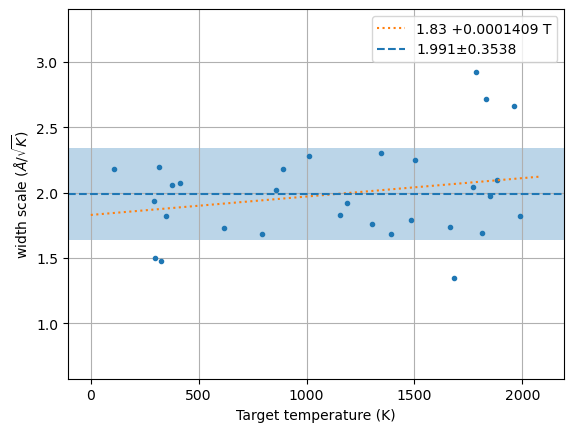

In [ ]:
#|vasp
# plt.semilogy()
wm = np.array(hecss._eta_list).T
y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
plt.plot(wm[1], y, '.');
x = np.linspace(0, 1.05*wm[1].max(), 2)
fit = np.polyfit(wm[1], y, 1)
plt.plot(x, np.polyval(fit, x), ':', label=f'{fit[1]:.4g} {fit[0]:+.4g} T')
plt.axhline(m, ls='--', label=f'{m:.4g}±{s:.4g}')
plt.axhspan(m-s, m+s, alpha=0.3)
plt.ylim(m-4*s, m+4*s)
# plt.ylim(0, m+4*s)
plt.xlabel('Target temperature (K)')
plt.ylabel('width scale ($\\AA/\\sqrt{K}$)')
plt.grid()
plt.legend();

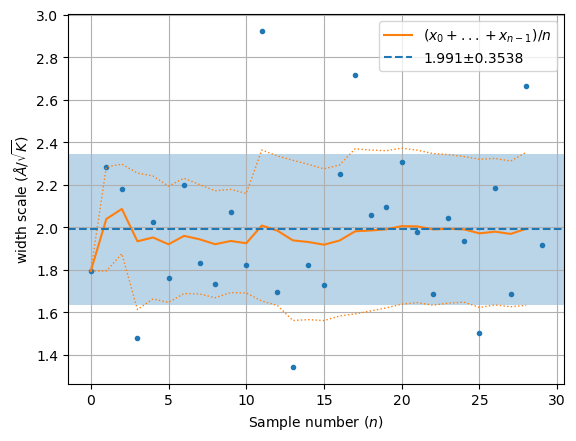

In [ ]:
#|vasp
wm = np.array(hecss._eta_list).T
y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
plt.plot(y, '.')
rm = np.array([y[:l].mean() for l in range(1, len(y))])
rv = np.array([y[:l].std() for l in range(1, len(y))])
plt.plot(rm, '-', label='$ (x_0 + ... + x_{n-1})/n$')
plt.plot(rm + rv, ':', lw=1, color='C1')
plt.plot(rm - rv, ':', lw=1, color='C1')
plt.axhline(m, ls='--', label=f'{m:.4g}±{s:.4g}')
plt.axhspan(m-s, m+s, alpha=0.3)
plt.xlabel('Sample number ($n$)')
plt.ylabel('width scale ($\\AA/\\sqrt{K}$)')
plt.grid()
plt.legend();


In [ ]:
#|hide
#|vasp
#|eval: false
CLEANUP=False

In [ ]:
#|hide
#|vasp
try :
    CLEANUP
except NameError:
    calc_dir.cleanup()

In [ ]:
#|hide
from ase.calculators import calculator
from ase.calculators.vasp.vasp import check_atoms

@patch
def calculate_par(self: Vasp,
                  atoms=None,
                  properties=('energy', ),
                  system_changes=tuple(calculator.all_changes)):
    """Do a VASP calculation in the specified directory.

    This will generate the necessary VASP input files, and then
    execute VASP. After execution, the energy, forces. etc. are read
    from the VASP output files.
    """
    # print(f"Parallel calculate in {self.directory}")

    self.clear_results()

    if atoms is not None:
        self.atoms = atoms.copy()

    # Check for zero-length lattice vectors and PBC
    # and that we actually have an Atoms object.
    check_atoms(self.atoms)

    command = self.make_command(self.command)
    self.write_input(self.atoms, properties, system_changes)

    with self._txt_outstream() as out:
        errorcode =  self._run(command=command,
                              out=out,
                              directory=self.directory)

    if errorcode:
        raise calculator.CalculationFailed(
            '{} in {} returned an error: {:d}'.format(
                self.name, self.directory, errorcode))

    # Read results from calculation
    # self.update_atoms(atoms)
    # self.read_results()

In [ ]:
#|hide
from time import sleep
from collections import deque

@patch 
def estimate_width_scale_par(self: HECSS, n=1, Tmax=600, set_scale=True, pbar=None):
    '''
    Estimate coefficient between temperature and displacement scale (eta).
    Calculate energy increase from the `n` temperatures uniformly 
    distributed between 0 and `Tmax` and calculate avarage $\sqrt{E-E0/T}$
    which is a width scale for a given temperature:
    $$
        w = \\eta\\sqrt{T}
    $$
    which comes from the assumed approximate relationship:
    $$
        \\frac{E(w(T))-E_0}{T} \\approx \\mathrm{const} = \\eta^2.
    $$
    
    #### Input
    * `n`    - number of sampling points
    * `Tmax` - max sampled temperature
    * `set_scale` - set scale parameter in the class after run
    * `pbar` - show progress bar during calculation
    
    #### Output
    * if wm_out :  mean(eta), std(eta), wm
    * else : mean(eta), std(eta)
    * wm - the nx3 array of: [width, Temperature, (E-E0)/nat]
    '''
    # print('Parallel estimate_width_scale')
    if self.Ep0 is None:
        self.Ep0 = self.cryst.get_potential_energy()
    E0 = self.Ep0
    nat = len(self.cryst)
    dim = (nat, 3)    
    
    if self.directory is None :
        basedir = f'calc'
    else :
        basedir = self.directory
        
    close_pbar = False
    
    if self.pbar and pbar is None:
        pbar = tqdm(total=n)
        close_pbar = True
    
    if pbar:
        pbar.reset(n)
        pbar.set_postfix_str('eta estimation')
        if self._eta_list:
            pbar.update(len(self._eta_list))

    # Build the queue
    structs = deque()
    if pbar:
       pbar.set_description('Create') 
    while len(structs) < n - len(self._eta_list):
        cr = ase.Atoms(self.cryst.get_atomic_numbers(), 
                       cell=self.cryst.get_cell(),
                       scaled_positions=self.cryst.get_scaled_positions(),
                       pbc=True, 
                       # calculator= self.calc() if callable(self.calc) 
                                               # else self.calc,
                      )
        
        T = stats.uniform.rvs(0, Tmax) # Kelvin
        if not T:
            continue
        w = self.w_scale * np.sqrt(T)
        dx = self.Q.rvs(size=dim, scale=w)

        clc = self.calc.__class__()
        clc.fromdict(self.calc.asdict())
        clc.atoms.set_positions(self.cryst.get_positions()+dx)
        # clc.set(directory=f'{basedir}/w_est/{len(self._eta_list)+len(structs):03d}')
        try :
            clc.set(directory=f'{basedir}/w_est/{len(self._eta_list)+len(structs):03d}')
        except AttributeError :
            # Calculator is not directory-based
            # Ignore the error
            pass
        clc.set(command=self.calc.command)
        structs.append((T, w, dx, clc))
        if pbar:
            pbar.update()
            
    if pbar:
        pbar.reset(n)
        pbar.set_description('Submit') 
    # Submit the calculations
    for T, w, dx, clc in structs:
        clc.calculate_par(clc.atoms)
        if pbar:
            pbar.update()

    if pbar:
        pbar.reset(n)
        pbar.set_description('Collect') 
    done = []
    while len(self._eta_list) < n:
        sleep(5)
        while structs:
            T, w, dx, clc = structs.popleft()
            try :
                clc.read_results()
            except (calculator.ReadError, 
                    FileNotFoundError, 
                    UnicodeDecodeError,
                    AttributeError
                   ):
                structs.append((T, w, dx, clc))
                continue
            # print(f'Done: {clc.directory}')
            done.append((T, w, dx, clc))
            E = clc.get_potential_energy()
            i = len(self._eta_list)
            self._eta_samples.append((i, i, dx, clc.get_forces(), (E-E0)/nat))
            self._eta_list.append([w, T, (E-E0)/nat])

            if pbar:
                pbar.update()

    wm = np.array(self._eta_list).T
    y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
    m = y.mean()
    
    xscale = np.ones(dim)
    vir = np.array([abs(s[2]*s[3]) for s in self._eta_samples])
    vir /= vir.mean(axis=(-1,-2))[:,None,None]

    elems = self.cryst.get_chemical_symbols()
    for n, el in enumerate(set(elems)):
        elmask = np.array(elems)==el
        xscale[elmask] = 1/np.sqrt(vir[:, elmask, :].mean())
    
    if pbar and close_pbar:
        pbar.close()
    
    if set_scale:
        self.eta = m
        self.xscale_init = xscale
        
    return m, y.std(), xscale